## **Using Siamese Network to differentiate between Real Signatures and Forged Signatures**




---

*   **Author: Tejas Krishna Reddy**
*   **NUID: 001423166**







Import all the necessery modules

In [1]:
import sys
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, AveragePooling2D, Activation, Input, concatenate, Dropout, ZeroPadding2D
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

In [2]:
## Mount the google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/My Drive/Signatures_2/Train_Set/"
os.chdir(path)
!ls

001  005  009  013  017  021  025  029	033  037  041  045  049  053  057  061
002  006  010  014  018  022  026  030	034  038  042  046  050  054  058  062
003  007  011  015  019  023  027  031	035  039  043  047  051  055  059  063
004  008  012  016  020  024  028  032	036  040  044  048  052  056  060  064


In [4]:
#dir_list = '001', '002'...
dir_list = next(os.walk(path))[1]
#print (os.listdir(path))

Read all the Paths for the data from folder for each image



In [5]:
## Read the data
real_groups, forg_groups = [], []
rlen, flen = [], []                                
for directory in dir_list:
    
    ## Read all Image names
    real_images = os.listdir(path+'/' +directory+'/Real')
    forg_images = os.listdir(path+ '/' + directory+ '/Forged')
    
    ## Create a full_path for each image in the directory and add in a list
    real_image_paths = [path+directory+'/Real/'+x for x in real_images]
    forged_image_paths = [path+directory+'/Forged/'+x for x in forg_images]
    
    ## Check how many images are in each path and store the number for reference
    rlen.append(len(real_image_paths))
    flen.append(len(forged_image_paths))
    
    ## Append the list of paths into a parent list.
    real_groups.append(real_image_paths) 
    forg_groups.append(forged_image_paths) 


In [6]:
### Define Fixed Params:
img_height = 100
img_width = 100

In [7]:
# A function to generate batches with the available groups of images 
def generate_batch(real_groups, forg_groups, batch_size = 30):
    
 
    while True:
        #### Create pairs
        real_pairs = []           # Real - Real image pair
        forg_pairs = []           # Real - Forged image pair
        all_pairs = []
        all_labels = []
        
        
        for real, forg in zip(real_groups, forg_groups):  #64 each
            real_pairs.extend(list(itertools.combinations(real, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(real[i:i+1], random.sample(forg, len(forg)))))
        
        # Label for real-real pairs is 1
        # Label for real-forged pairs is 0
        real_real_labels = [1]*len(real_pairs)
        real_for_labels = [0]*len(forg_pairs)
        
        
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = real_pairs + forg_pairs
        all_labels = real_real_labels + real_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        
        
        
        ## Read the images from the paths, resize them, convert to 1D np array and store corresponding labels        
        k = 0
        pairs=[np.zeros((batch_size, img_height, img_width, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        
        for ix, pair in enumerate(all_pairs):
            ## Read Images
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            
            # Resize
            img1 = cv2.resize(img1, (img_width, img_height))
            img2 = cv2.resize(img2, (img_width, img_height))
            
            ## Convert to np arrays
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            
            ## Add a third axis, make it into shape = (250, 250, 1)
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
    
            ## Convert them into a 1D array
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            
            ## Store the corresponding labels
            targets[k] = all_labels[ix]
            k += 1
            
            ## If batch is full, then yeild the batch
            if k == batch_size:
                yield pairs, targets
                
                # Reset Params for next batch
                k = 0
                pairs=[np.zeros((batch_size, img_height, img_width, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))
        

In [8]:
### Defining a Base Siamese Network for both images
def Base_Siamese_Network(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(3, 3), activation='relu', name='conv1_1', strides=1, 
                   input_shape= input_shape))
    seq.add(AveragePooling2D((2,2), strides=(2, 2), padding = 'same'))    
    
    seq.add(Conv2D(200, kernel_size=(3, 3), activation='relu', name='conv2_1', strides=1))
    seq.add(AveragePooling2D((2,2), strides=(2, 2), padding = 'same'))
    #seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1)))
    
    
    #seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(128, activation='relu'))   
    seq.add(Dense(128, activation='relu')) 
    
    return seq


In [9]:
### Defining functions for loss functions and distance measures
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))



In [10]:
#### Divide val and Train
real_train, real_val = real_groups[:50], real_groups[50:]
forg_train, forg_val = forg_groups[:50], forg_groups[50:]    

In [11]:

### A function to return the length of train and test samples for the available number of images in each group 
def len_of_all_pairs(real_groups, forg_groups):

    #### Create pairs
    real_pairs = []           # Real - Real image pair
    forg_pairs = []           # Real - Forged image pair
    all_pairs = []
    all_labels = []
    
    
    for real, forg in zip(real_groups, forg_groups):  #64 each
        real_pairs.extend(list(itertools.combinations(real, 2)))
        for i in range(len(forg)):
            forg_pairs.extend(list(itertools.product(real[i:i+1], random.sample(forg, len(forg)))))
    
    # Label for real-real pairs is 1
    # Label for real-forged pairs is 0
    real_real_labels = [1]*len(real_pairs)
    real_for_labels = [0]*len(forg_pairs)
    
    
    
    # Concatenate all the pairs together along with their labels and shuffle them
    all_pairs = real_pairs + forg_pairs
    all_labels = real_real_labels + real_for_labels
    all_pairs, all_labels = shuffle(all_pairs, all_labels)
    
    return(len(all_pairs))

In [12]:
## Calcualte length of samples for train and test case
num_train_samples = len_of_all_pairs(real_train, forg_train)
num_val_samples = len_of_all_pairs(real_val, forg_val)
batch_sz = 30


In [13]:
# network definition
input_shape = (img_height, img_width, 1)
base_network = Base_Siamese_Network(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)


In [14]:
### Fit the model with the training data and validate it on validation data.
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)


results = model.fit_generator(generate_batch(real_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 20,
                              validation_data = generate_batch(real_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
418/418 [==============================] - 174s 417ms/step - loss: 0.0846 - val_loss: 0.0591
Epoch 2/20
418/418 [==============================] - 170s 406ms/step - loss: 0.0144 - val_loss: 0.0526
Epoch 3/20
418/418 [==============================] - 166s 397ms/step - loss: 0.0068 - val_loss: 0.0432
Epoch 4/20
418/418 [==============================] - 168s 401ms/step - loss: 0.0047 - val_loss: 0.0551
Epoch 5/20
418/418 [==============================] - 166s 396ms/step - loss: 0.0035 - val_loss: 0.0565
Epoch 6/20
418/418 [==============================] - 162s 388ms/step - loss: 0.0026 - val_loss: 0.0503
Epoch 7/20
418/418 [==============================] - 160s 383ms/step - loss: 0.0024 - val_loss: 0.0462
Epoch 8/20
418/418 [==============================] - 161s 385ms/step - loss: 0.0021 - val_loss: 0.0486
Epoch 9/20
418/418 [==============================] - 160s 382ms/step - loss: 0.0017 - val_l

In [15]:
## A function to compute accuracy and optimal threshold for prediction analysis
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh


In [16]:
## Generate a test batch to check its validation accuracy
test_gen = generate_batch(real_val, forg_val, 1)
pred, tr_y = [], []
for i in range(num_val_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])



In [17]:
# Print validation accuracy and threshold
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold


(0.9670788770053476, 0.2799162214994431)

In [18]:
## A function to display samples and their result of classification.
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")


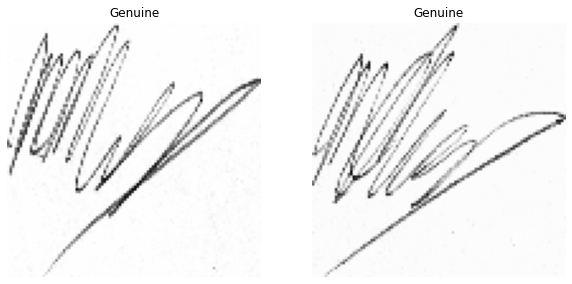

Difference Score =  0.14578772
Its a Genuine Signature


In [19]:
# Validation set examples
predict_score()

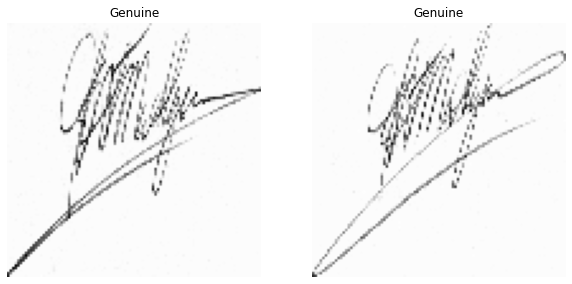

Difference Score =  0.059697773
Its a Genuine Signature


In [20]:

predict_score()

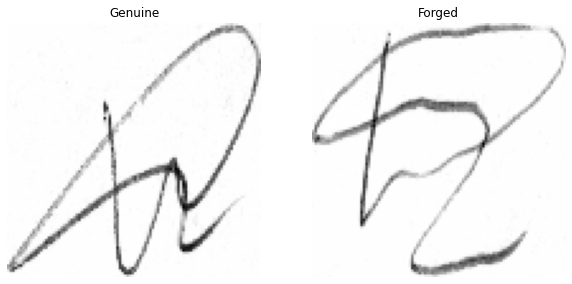

Difference Score =  0.2604548
Its a Genuine Signature


In [21]:

predict_score()

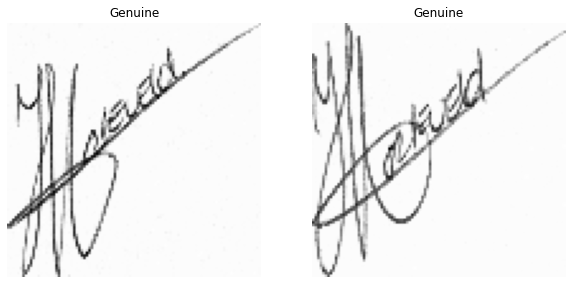

Difference Score =  0.2147054
Its a Genuine Signature


In [22]:

predict_score()

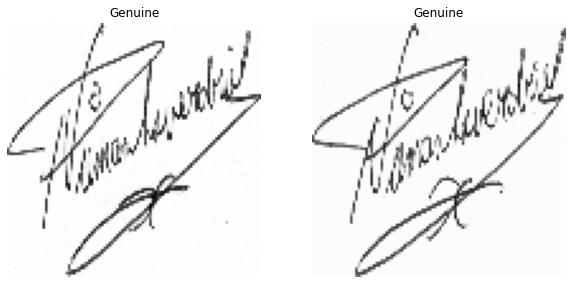

Difference Score =  0.1094851
Its a Genuine Signature


In [23]:

predict_score()

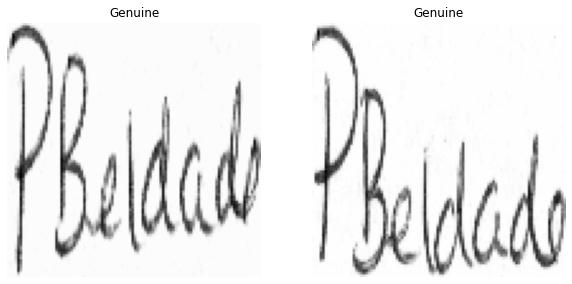

Difference Score =  0.18574136
Its a Genuine Signature


In [24]:

predict_score()

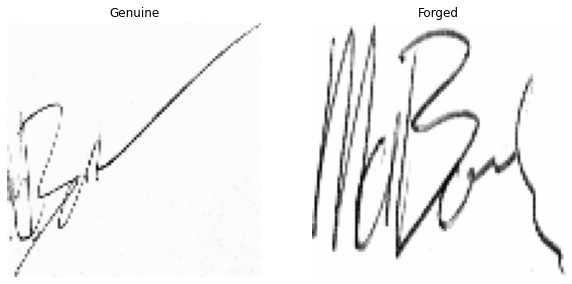

Difference Score =  7.557686
Its a Forged Signature


In [25]:

predict_score()

### *Now do the same analysis for testing*

In [26]:
### Apply the trained model on Test Set!!!
path = "/content/drive/My Drive/Signatures_2/Test_Set/"

#dir_list = '001', '002'...
dir_list = next(os.walk(path))[1]

In [27]:
## Read the data
real_groups_test, forg_groups_test = [], []                         
for directory in dir_list:
    
    ## Read all Image names
    real_images = os.listdir(path+'/' +directory+'/Real')
    forg_images = os.listdir(path+ '/' + directory+ '/Forged')
    
    ## Create a full_path for each image in the directory and add in a list
    real_image_paths = [path+directory+'/Real/'+x for x in real_images]
    forged_image_paths = [path+directory+'/Forged/'+x for x in forg_images]
    
    ## Append the list of paths into a parent list.
    real_groups_test.append(real_image_paths) 
    forg_groups_test.append(forged_image_paths) 


In [28]:
num_of_test_samples = len_of_all_pairs(real_groups_test, forg_groups_test)

test_gen = generate_batch(real_groups_test, forg_groups_test, 1)
pred_test, tr_y_test = [], []
for i in range(num_of_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y_test.append(label)
    pred_test.append(model.predict([img1, img2])[0][0])

In [29]:
# Printing Training Accuracy
tr_acc_test, threshold_test = compute_accuracy_roc(np.array(pred_test), np.array(tr_y_test))
print('Training Accuracy: ', tr_acc_test)



Training Accuracy:  0.9791821348870768


In [30]:
## A function to print the test images and their results.
def predict_test():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")



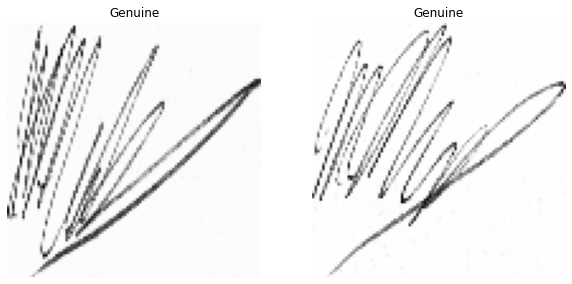

Difference Score =  0.09506219
Its a Genuine Signature


In [31]:
### Printing a test sample with their results
predict_test()

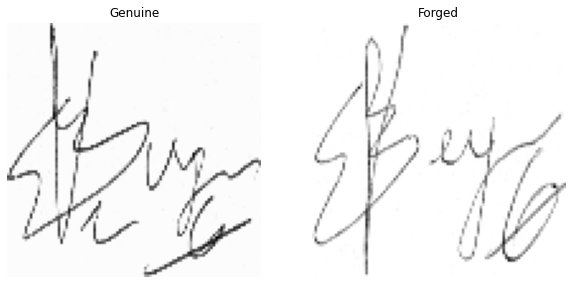

Difference Score =  1.3013374
Its a Forged Signature


In [32]:
predict_test()

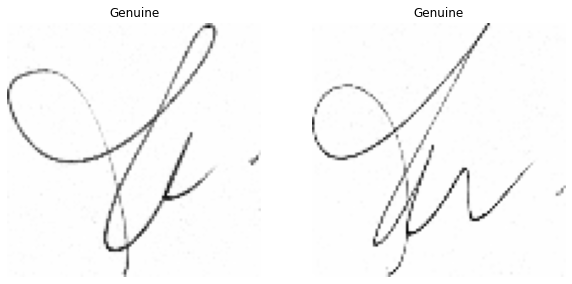

Difference Score =  0.017931737
Its a Genuine Signature


In [33]:
predict_test()

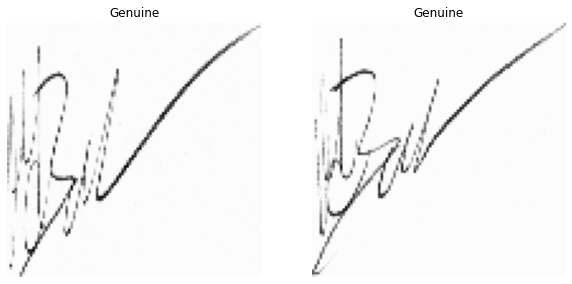

Difference Score =  0.1044879
Its a Genuine Signature


In [34]:
predict_test()

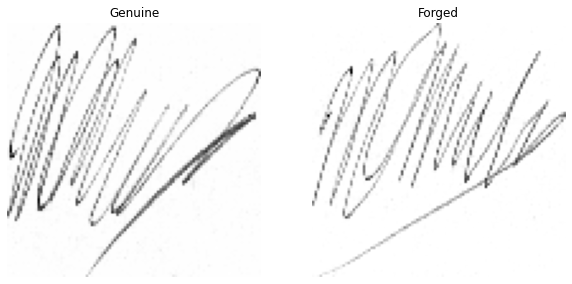

Difference Score =  0.49496564
Its a Forged Signature


In [35]:
predict_test()

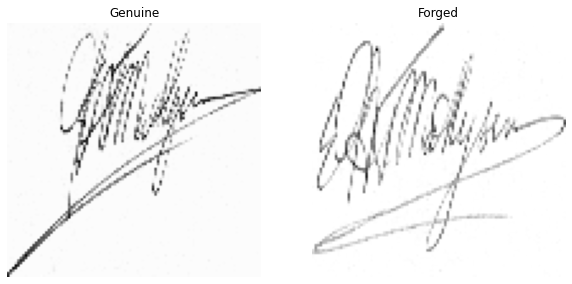

Difference Score =  1.2296127
Its a Forged Signature


In [36]:
predict_test()

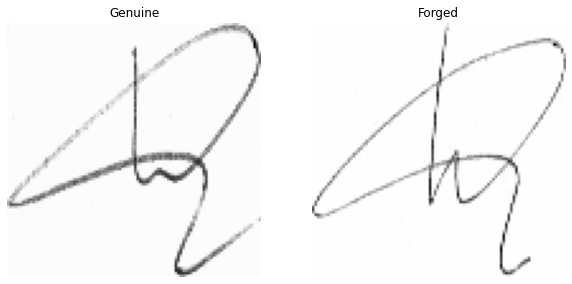

Difference Score =  1.3465387
Its a Forged Signature


In [37]:
predict_test()